<a href="https://www.kaggle.com/code/goharpetrosyan06/lung-segmentation-v1-pytorch?scriptVersionId=237908879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, dropout_rate=0.1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, dropout_rate=dropout_rate)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128, dropout_rate=dropout_rate))
        self.down2 = (Down(128, 256, dropout_rate=dropout_rate))
        self.down3 = (Down(256, 512, dropout_rate=dropout_rate))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor, dropout_rate=dropout_rate))
        self.up1 = (Up(1024, 512 // factor, bilinear, dropout_rate=dropout_rate))
        self.up2 = (Up(512, 256 // factor, bilinear, dropout_rate=dropout_rate))
        self.up3 = (Up(256, 128 // factor, bilinear, dropout_rate=dropout_rate))
        self.up4 = (Up(128, 64, bilinear, dropout_rate=dropout_rate))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
PATCH_SIZE = (256, 256)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
unet = UNet(1, 2, bilinear=False, dropout_rate=0.1).to(DEVICE)

unet = nn.DataParallel(unet)
unet.load_state_dict(torch.load("/kaggle/input/best_model/pytorch/default/1/best_model.pth", map_location=torch.device(DEVICE)))

<All keys matched successfully>

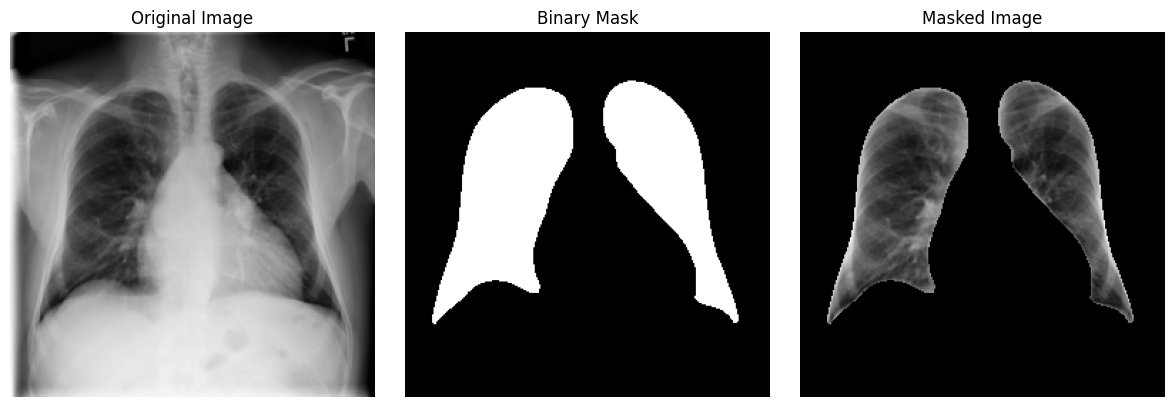

In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def plot_examples(model):
    model.eval()
    
    image_transform = transforms.Compose([
        transforms.Resize(size=PATCH_SIZE, antialias=True),
        transforms.ToTensor()
    ])
    image = Image.open("/kaggle/input/data/images_001/images/00000001_000.png").convert("L")
    image = image_transform(image)           # shape: [1, H, W]
    
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(DEVICE)).cpu()  # [1, num_classes, H, W]
    pred_mask = torch.argmax(output, dim=1)                  # [1, H, W]
    
    binary_mask = (pred_mask == 1).float()  # [1, H, W]
    
    masked_image = image * binary_mask
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis("off")
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask.squeeze(), cmap='gray')
    plt.axis("off")
    plt.title('Binary Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.axis("off")
    plt.title('Masked Image')
    
    plt.tight_layout()
    plt.show()

plot_examples(unet)

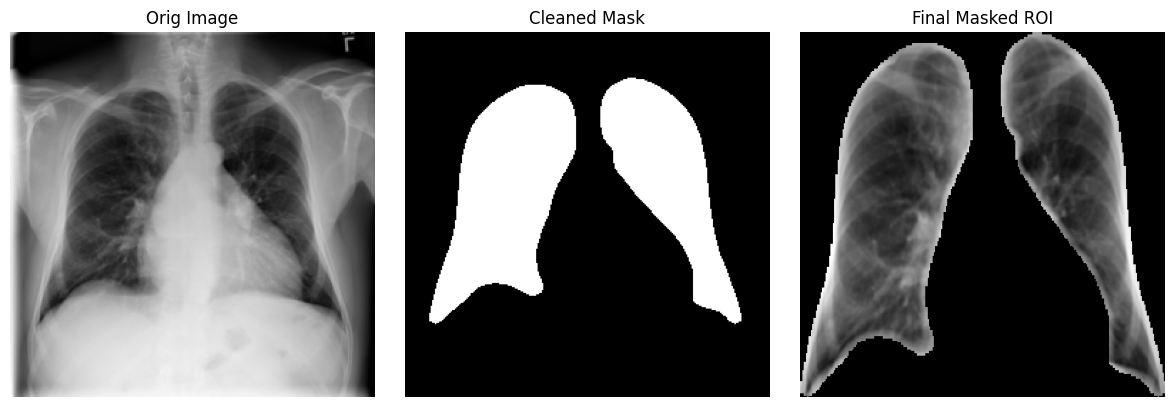

In [7]:
import cv2                     # OpenCV for fast morphology & bounding‐box ops

def plot_examples(model):
    model.eval()
    image = Image.open("/kaggle/input/data/images_001/images/00000001_000.png").convert("L")
    image = transforms.Resize(PATCH_SIZE, antialias=True)(image)
    image = transforms.ToTensor()(image)               # [1, H, W]

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(DEVICE)).cpu()
    pred_mask = torch.argmax(output, dim=1).float()    # [1, H, W]
    
    # Morphology (opening + dilation)
    mask_np = pred_mask.squeeze().numpy().astype(np.uint8)
    kernel  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened  = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
    dilated = cv2.morphologyEx(opened, cv2.MORPH_DILATE, kernel)
    binary_mask = torch.from_numpy(dilated).unsqueeze(0)

    # Crop ROI via boundingRect
    coords = cv2.findNonZero(dilated)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_img  = image[:, y : y+h, x : x+w]
    cropped_mask = binary_mask[:, y : y+h, x : x+w]

    # Resize to 300×300
    batch_img  = cropped_img.unsqueeze(0)
    batch_mask = cropped_mask.unsqueeze(0)
    resized_img  = F.interpolate(batch_img, size=(300,300), mode='bilinear',    align_corners=False).squeeze(0)
    resized_mask = F.interpolate(batch_mask, size=(300,300), mode='nearest').squeeze(0)
    masked_image = resized_img * resized_mask

    # Plotting
    plt.figure(figsize=(12, 4))
    for i, (img, msk, title) in enumerate([
            (image.squeeze(), pred_mask.squeeze(), 'Orig Image'),
            (dilated,        dilated,            'Cleaned Mask'),
            (masked_image.squeeze(), resized_mask.squeeze(), 'Final Masked ROI')
        ], 1):
        plt.subplot(1, 3, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()

plot_examples(unet)

In [8]:
def get_nodule(model, image):
    model.eval()
    image = transforms.Resize(PATCH_SIZE, antialias=True)(image)
    image = transforms.ToTensor()(image)               # [1, H, W]

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(DEVICE)).cpu()
    pred_mask = torch.argmax(output, dim=1).float()
    
    mask_np = pred_mask.squeeze().numpy().astype(np.uint8)
    kernel  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened  = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
    dilated = cv2.morphologyEx(opened, cv2.MORPH_DILATE, kernel)
    binary_mask = torch.from_numpy(dilated).unsqueeze(0)

    coords = cv2.findNonZero(dilated)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_img  = image[:, y : y+h, x : x+w]
    cropped_mask = binary_mask[:, y : y+h, x : x+w]

    batch_img  = cropped_img.unsqueeze(0)
    batch_mask = cropped_mask.unsqueeze(0)
    resized_img  = F.interpolate(batch_img, size=(300,300), mode='bilinear',    align_corners=False).squeeze(0)
    resized_mask = F.interpolate(batch_mask, size=(300,300), mode='nearest').squeeze(0)
    masked_image = resized_img * resized_mask
    return masked_image

In [9]:
import pandas as pd
from sklearn.utils import resample

df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

nodule_mask     = df['Finding Labels'].apply(lambda labels: 'Nodule' in labels.split('|'))
other_mask      = ~nodule_mask

nodule_df       = df[nodule_mask]
others_df       = df[other_mask]

all_labels = [
    "Atelectasis", "Consolidation", "Infiltration", "Pneumothorax",
    "Edema", "Emphysema", "Fibrosis", "Effusion", "Pneumonia",
    "Cardiomegaly", "Mass", "Hernia", "No Finding"
]

n_samples_per_label = 6333 // len(all_labels)
remainder = 6333 % len(all_labels)

samples = []

for label in all_labels:
    lbl_mask = others_df['Finding Labels'].apply(lambda labels: label in labels.split('|'))
    subset  = others_df[lbl_mask]

    take = n_samples_per_label + (1 if remainder > 0 else 0)
    remainder -= 1 if remainder > 0 else 0

    actual_take = min(take, len(subset))
    if actual_take == 0:
        continue

    sampled = resample(subset, replace=False, n_samples=actual_take, random_state=42)
    samples.append(sampled)

second_df = pd.concat(samples).drop_duplicates(subset='Image Index')

if len(second_df) < 6333:
    remaining = others_df[~others_df['Image Index'].isin(second_df['Image Index'])]
    needed = 6333 - len(second_df)
    filler = resample(remaining, replace=False, n_samples=needed, random_state=42)
    second_df = pd.concat([second_df, filler])

second_df = second_df.sample(n=6333, random_state=42).reset_index(drop=True)

print(len(second_df))

print(len(nodule_df))
print(set(second_df['Image Index']).isdisjoint(nodule_df['Image Index']))

print("Done!  second_df has", len(second_df), "unique non‑nodule studies.")

6333
6331
True
Done!  second_df has 6333 unique non‑nodule studies.


In [10]:
import os
import zipfile
import pandas as pd
from PIL import Image
import os
import pandas as pd
import zipfile
from torchvision import transforms
from PIL import Image

source_base_dir = '/kaggle/input/data/'

OUT_BASE = "/kaggle/working/processed_lungs"
os.makedirs(os.path.join(OUT_BASE, "nodule"),    exist_ok=True)
os.makedirs(os.path.join(OUT_BASE, "non_nodule"), exist_ok=True)

folder_ranges = [
    (1335, 6, 'images_001'),
    (3923, 13, 'images_002'),
    (6585, 6, 'images_003'),
    (9232, 3, 'images_004'),
    (11558, 7, 'images_005'),
    (13774, 25, 'images_006'),
    (16051, 9, 'images_007'),
    (18387, 34, 'images_008'),
    (20945, 49, 'images_009'),
    (24717, 0, 'images_010'),
    (28173, 2, 'images_011'),
    (30805, 0, 'images_012')
]
records = []
for cohort_df, label_value in [(nodule_df, 1.0), (second_df, 0.0)]:
    subfolder = "nodule" if label_value == 1.0 else "non_nodule"
    out_dir   = os.path.join(OUT_BASE, subfolder)
    
    for _, row in cohort_df.iterrows():
        image_filename = row['Image Index']
        
        base_name = os.path.splitext(image_filename)[0]
        part1_str, part2_str = base_name.split('_')
        part1, part2 = int(part1_str), int(part2_str)

        source_folder = None
        for f_part1, f_part2, f_name in folder_ranges:
            if part1 < f_part1 or (part1 == f_part1 and part2 <= f_part2):
                source_folder = f_name
                break
        if not source_folder:
            continue

        img_path = os.path.join(source_base_dir,
                                source_folder,
                                'images',
                                image_filename)

        image = Image.open(img_path).convert('L')
        image = get_nodule(unet, image)
        
        pil_img = transforms.ToPILImage()(image)
        save_name = f"{base_name}_lung.png"
        save_path = os.path.join(out_dir, save_name)
        pil_img.save(save_path)

        records.append({
            "filename": save_name,
            "label":    int(label_value)
        })

df_out = pd.DataFrame(records)
csv_path = os.path.join(OUT_BASE, "labels.csv")
df_out.to_csv(csv_path, index=False)
print(f"Saved {len(records)} processed lungs and labels.csv to {OUT_BASE}")

zip_path = "/kaggle/working/processed_lungs.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(OUT_BASE):
        for fname in files:
            full = os.path.join(root, fname)
            # write with relative path inside the zip
            rel  = os.path.relpath(full, os.path.dirname(OUT_BASE))
            zf.write(full, rel)

print(f"Created ZIP archive at {zip_path}")

✅ Saved 12664 processed lungs and labels.csv to /kaggle/working/processed_lungs
📦 Created ZIP archive at /kaggle/working/processed_lungs.zip
